# Predict whether or not NY Times articles will be popular.  6532 articles training, 1870 testing

# What the raw data looks like

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import time
import datetime
from collections import Counter

df = pd.read_csv('../NYTimesBlogTrain.csv')
df.head()

,NewsDesk,SectionName,SubsectionName,Headline,Snippet,Abstract,WordCount,PubDate,Popular,UniqueID
0,Business,Crosswords/Games,NaN,More School Daze,A puzzle from Ethan Cooper that reminds me tha...,A puzzle from Ethan Cooper that reminds me tha...,508,2014-09-01 22:00:09,1,1
1,Culture,Arts,NaN,New 96-Page Murakami Work Coming in December,The Strange Library will arrive just three and...,The Strange Library will arrive just three and...,285,2014-09-01 21:14:07,0,2
2,Business,Business Day,Dealbook,Public Pension Funds Stay Mum on Corporate Expats,Public pension funds have major stakes in Amer...,Public pension funds have major stakes in Amer...,1211,2014-09-01 21:05:36,0,3
3,Business,Business Day,Dealbook,Boot Camp for Bankers,As they struggle to find new business to bolst...,As they struggle to find new business to bolst...,1405,2014-09-01 20:43:34,1,4
4,Science,Health,NaN,Of Little Help to Older Knees,Middle-aged and older patients are unlikely to...,Middle-aged and older patients are unlikely to...,181,2014-09-01 18:58:51,1,5


# Convert PubDate to milliseconds, replace null values with the median value

In [2]:
y = df['Popular'] 

# convert date to timestamp (milliseconds, divide by a million to get a more readable decimal)
df['PubDate'] = df['PubDate'].apply(lambda x: time.mktime(time.strptime(x, '%Y-%m-%d %H:%M:%S'))/1000000)

#replace empty values with the middle most common word

def nan_to_meaningful(x, col):
    if pd.isnull(x):
        mc = Counter(col).most_common(8)
        mc = [str(i[0]) for i in mc]
        if 'nan' in mc:
            mc.remove('nan')
        rep = mc.pop((len(mc))//2)
        return rep
        
    return x
        
my_list = ["NewsDesk","SectionName","SubsectionName","Headline","Snippet","Abstract"]

for f in my_list: 
    df[f] = df[f].apply(nan_to_meaningful, args=(df[f],))


# Convert columns that contain sentences into Series of words, so each word can be a column

In [3]:
# split sentences into series of words so each word can be a column
def string_to_series_of_words(x):    
    return pd.Series(x.split(" "))


for f in my_list[3:]:
    df[f] = df[f].apply(string_to_series_of_words)

# use get_dummies to make the words in each column a column, print the new columns(features)

In [4]:
df=pd.get_dummies(df,columns=["NewsDesk","SectionName","SubsectionName", "Headline","Snippet","Abstract"],
                  drop_first=False)

new_features = list(df.dtypes.index)
new_features.remove('Popular')

X = df[new_features]

print(new_features)

#originally 9, now 5452

print("\nTotal features: ", len(new_features))

['WordCount', 'PubDate', 'UniqueID', 'NewsDesk_Business', 'NewsDesk_Culture', 'NewsDesk_Foreign', 'NewsDesk_Magazine', 'NewsDesk_Metro', 'NewsDesk_National', 'NewsDesk_OpEd', 'NewsDesk_Science', 'NewsDesk_Sports', 'NewsDesk_Styles', 'NewsDesk_TStyle', 'NewsDesk_Travel', 'SectionName_Arts', 'SectionName_Business Day', 'SectionName_Crosswords/Games', 'SectionName_Health', 'SectionName_Magazine', 'SectionName_Multimedia', 'SectionName_N.Y. / Region', 'SectionName_Open', 'SectionName_Opinion', 'SectionName_Sports', 'SectionName_Style', 'SectionName_Technology', 'SectionName_Travel', 'SectionName_U.S.', 'SectionName_World', 'SubsectionName_Asia Pacific', 'SubsectionName_Dealbook', 'SubsectionName_Education', 'SubsectionName_Fashion & Style', 'SubsectionName_Politics', 'SubsectionName_Room For Debate', 'SubsectionName_Small Business', 'SubsectionName_The Public Editor', 'Headline_', 'Headline_"An', 'Headline_"Gigi"', 'Headline_"Honey', 'Headline_"Please', 'Headline_$1', 'Headline_$1.5', 'Hea

# Random forest

In [5]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
rf =  RandomForestClassifier(n_estimators = 50, bootstrap = True, random_state=0, criterion='entropy')
rf.fit(X_train, y_train)

y_predict_randF = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_predict_randF)

print("\nAccuracy: ", accuracy) 


Accuracy:  0.909785932722


# DecisionTreeClassifier

In [6]:
decTree =  DecisionTreeClassifier(criterion='entropy', min_samples_split=4, random_state=0)
decTree.fit(X_train, y_train)
y_predict_decTree = decTree.predict(X_test)

accuracy_decTree = accuracy_score(y_test, y_predict_decTree)

print("\nAccuracy Decision Tree: ", accuracy_decTree) 


Accuracy Decision Tree:  0.906727828746


# ExtraTreesClassifier

In [7]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(n_estimators=52, max_depth=None, min_samples_split=5, random_state=0, criterion='entropy')
etc.fit(X_train,y_train)

predictions_etc = etc.predict(X_test)
accuracy_etc = accuracy_score(y_test, predictions_etc)

print("\nAccuracy ExtraTreesClassifier: ", accuracy_etc) 


Accuracy ExtraTreesClassifier:  0.911314984709


# Combining the results of the best classifiers

In [8]:
combined_predictions=pd.DataFrame([y_predict_randF, y_predict_decTree, predictions_etc])

consolidated_predictions = list(combined_predictions.mode().values[0])

acc= accuracy_score(y_test, consolidated_predictions)

print("\n Combined Accuracy: ", acc) 


 Combined Accuracy:  0.915902140673


# Additional classifiers tried

# Gradient Boosting Classifier

In [9]:
#Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
acc_score = accuracy_score(y_test, prediction)
print("Accuracy by Gradient Boosting Classifier: ", acc_score)

Accuracy by Gradient Boosting Classifier:  0.899082568807


# Ada boost

In [10]:
#Ada boost
from sklearn.ensemble import AdaBoostClassifier
dt = DecisionTreeClassifier()
clf = AdaBoostClassifier(n_estimators=100, base_estimator=dt,learning_rate=1)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
acc_score = accuracy_score(y_test, prediction)
print("Accuracy by Ada Boost Classifier: ", acc_score)

Accuracy by Ada Boost Classifier:  0.894495412844


# LogisticRegression

In [11]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

# training
logreg.fit(X_train, y_train)

# predict label
y_predict_lr = logreg.predict(X_test)

# calculate accuracy
log_accuracy = accuracy_score(y_test, y_predict_lr)

print('Logistic Regression: ', log_accuracy)

Logistic Regression:  0.899082568807


In [12]:
from sklearn import metrics

y_predict_prob_lr = logreg.predict_proba(X_test)

print(y_predict_prob_lr[:  ,1])


# calculate AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob_lr[:,1], pos_label=1)
AUC = metrics.auc(fpr, tpr)
print('AUC: ',AUC)

[ 0.05076557  0.0735996   0.0070257   0.76816447  0.0910532   0.06226893
  0.12518057  0.01018791  0.13368947  0.01739112  0.01959668  0.82794335
  0.03343846  0.70227282  0.06896322  0.89250545  0.19216822  0.07134319
  0.14698745  0.09539881  0.05102117  0.05086081  0.81847508  0.01415613
  0.01759833  0.06870239  0.02359446  0.03996147  0.02164081  0.10542668
  0.07997093  0.06490655  0.00662386  0.01604112  0.08229058  0.03549646
  0.0682649   0.04687843  0.67520279  0.04581312  0.04056713  0.01576654
  0.06432742  0.00740204  0.04224841  0.04044595  0.01256732  0.05238873
  0.00486712  0.11537147  0.21622266  0.10823779  0.08540876  0.69751132
  0.58045555  0.05877715  0.0378992   0.7535326   0.03156605  0.01510592
  0.24819339  0.2146104   0.03909652  0.68390739  0.23672907  0.07032447
  0.04770211  0.01375246  0.05657037  0.02397154  0.2293248   0.01288247
  0.07232565  0.10041018  0.04418179  0.03838214  0.05133479  0.08048
  0.04080508  0.06051366  0.0113216   0.01363984  0.09

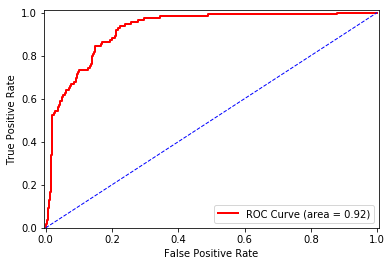

In [13]:
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()

# Roc Curve:
plt.plot(fpr, tpr, color='red', lw=2, 
         label='ROC Curve (area = %0.2f)' % AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Define X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")

plt.show()

# K - Nearest Neighbors

In [14]:
from sklearn.neighbors import KNeighborsClassifier

k=27
y = df['Popular'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
my_knn = KNeighborsClassifier(n_neighbors=k)
my_knn.fit(X_train, y_train)
y_predict = my_knn.predict(X_test)
accuracyKnn = accuracy_score(y_test, y_predict)
print("Accuracy using KNN", accuracyKnn)

Accuracy using KNN 0.833163265306


# Neural Networks

In [15]:
from sklearn.neural_network import MLPClassifier

y = df['Popular'] 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=0)

clf = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(8), random_state=0)
clf.fit(X_train,y_train)

predictions = clf.predict(X_test)

predictions
accuracyNN = accuracy_score(y_test, predictions)

print("Accuracy on training data by Neural Networks: ", accuracyNN)

Accuracy on training data by Neural Networks:  0.873979591837


### Cross Validation with Neural Networks 

In [16]:
# importing the method:
from sklearn.model_selection import cross_val_score


decisionTree = DecisionTreeClassifier()
clf = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(8), random_state=0)


accuracy_list = cross_val_score(clf, X, y, cv=10)

accuracy_gb = accuracy_list.mean()

print("Accuracy Using Cross Validation With Neural Networks",accuracy_gb)

Accuracy Using Cross Validation With Neural Networks 0.853040942921


<h1> Gaussian Naive Bayes </h1>

Accuracy for Gaussian Naive Bayes: 0.703363914373
Confusion matrix, without normalization
[[365 180]
 [ 14  95]]
Normalized confusion matrix
[[ 0.67  0.33]
 [ 0.13  0.87]]


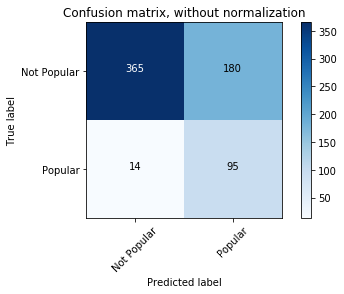

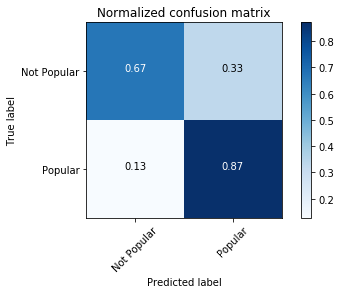

AUC:  0.84120023567


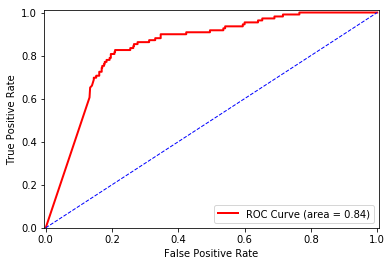

In [17]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_predict_gaus = gnb.predict(X_test)
accuracy_gaus = accuracy_score(y_test, y_predict_gaus)

print("Accuracy for Gaussian Naive Bayes:", accuracy_gaus)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predict_gaus)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Not Popular', 'Popular'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Not Popular', 'Popular'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

y_predicts = gnb.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicts[:,1], pos_label=1)
AUC = metrics.auc(fpr, tpr)
print('AUC: ',AUC)

plt.figure()

# Roc Curve:
plt.plot(fpr, tpr, color='red', lw=2, 
         label='ROC Curve (area = %0.2f)' % AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Define X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")

plt.show()

<h1> Multinomial Naive Bayes </h1>

Accuracy of Mean Shift algorithm:  0.714067278287
Confusion matrix, without normalization
[[408 137]
 [ 50  59]]
Normalized confusion matrix
[[ 0.75  0.25]
 [ 0.46  0.54]]


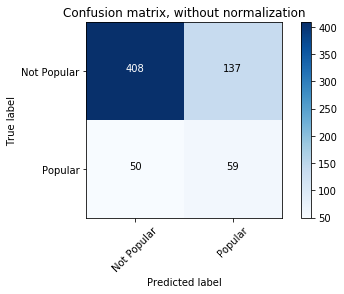

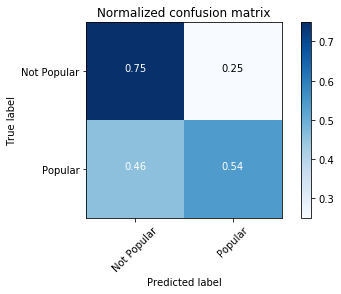

AUC:  0.674640181803


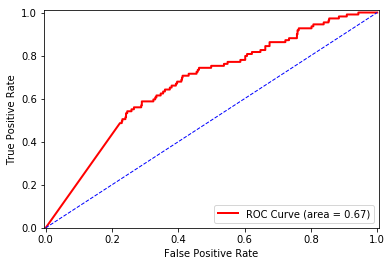

In [19]:
from sklearn.naive_bayes import MultinomialNB
mlt = MultinomialNB()
mlt.fit(X, y)
y_predict_mlt = mlt.predict(X_test)
accuracy_mlt = accuracy_score(y_test, y_predict_mlt)
print("Accuracy of Multinomial Naive Bayes: ", accuracy_mlt)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predict_mlt)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Not Popular', 'Popular'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Not Popular', 'Popular'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

y_predicts = mlt.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicts[:,1], pos_label=1)
AUC = metrics.auc(fpr, tpr)
print('AUC: ',AUC)

plt.figure()

# Roc Curve:
plt.plot(fpr, tpr, color='red', lw=2, 
         label='ROC Curve (area = %0.2f)' % AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Define X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")

plt.show()